In [1]:
print("hello")

hello


In [28]:
!pwd

/home/jovyan


In [6]:
!curl -L -o /home/jovyan/c-sample-data.zip\
  https://www.kaggle.com/api/v1/datasets/download/jinquan/cc-sample-data

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  210M  100  210M    0     0  1586k      0  0:02:15  0:02:15 --:--:-- 2036k      0  0:02:28  0:01:28  0:01:00  739k9  145M    0     0  1503k      0  0:02:23  0:01:38  0:00:45 2313k


In [9]:
!unzip c-sample-data.zip

Archive:  c-sample-data.zip
  inflating: cc_sample_transaction.json  


# Dependency

In [366]:
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
        aes_encrypt, aes_decrypt, lit, base64, col, when, 
        count, isnan, split, size, reverse, from_unixtime, expr, 
        asc, desc, to_date, month, year, concat, regexp_replace, shuffle, trim
    )
import pyspark.sql.functions as f

from pyspark.sql.functions import from_utc_timestamp

In [2]:
spark = SparkSession.builder.appName("paynet assignment").\
            config("spark.memory.offHeap.enabled", "true").\
                config("spark.memory.offHeap.size", "10g").\
                    getOrCreate()

# Simple EDA

In [96]:
df = spark.read.json("cc_sample_transaction.json")
df.printSchema()

root
 |-- Unnamed: 0: string (nullable = true)
 |-- amt: string (nullable = true)
 |-- category: string (nullable = true)
 |-- cc_bic: string (nullable = true)
 |-- cc_num: string (nullable = true)
 |-- is_fraud: string (nullable = true)
 |-- merch_eff_time: string (nullable = true)
 |-- merch_last_update_time: string (nullable = true)
 |-- merch_lat: string (nullable = true)
 |-- merch_long: string (nullable = true)
 |-- merch_zipcode: string (nullable = true)
 |-- merchant: string (nullable = true)
 |-- personal_detail: string (nullable = true)
 |-- trans_date_trans_time: string (nullable = true)
 |-- trans_num: string (nullable = true)



In [5]:
df.count()

1296675

In [6]:
df.show(2)

+----------+------+-----------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|   category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-----------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|   misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
|         1|107.23|grocery_pos|   ADMDUS

In [97]:
import ast
from pyspark.sql.functions import first

per_det = df.select(first('personal_detail')).collect()[0][0]
ast.literal_eval(per_det)

{'person_name': 'Jennifer,Banks,eeeee',
 'gender': 'F',
 'address': '{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}',
 'lat': '36.0788',
 'long': '-81.1781',
 'city_pop': '3495',
 'job': 'Psychologist, counselling',
 'dob': '1988-03-09'}

In [20]:
mer = df.select(first('merchant')).collect()[0][0]
mer

'fraud_Rippin, Kub and Mann'

In [23]:
df.select('category').distinct().collect()

[Row(category='travel'),
 Row(category='misc_net'),
 Row(category='grocery_pos'),
 Row(category='kids_pets'),
 Row(category='shopping_net'),
 Row(category='grocery_net'),
 Row(category='food_dining'),
 Row(category='gas_transport'),
 Row(category='personal_care'),
 Row(category='health_fitness'),
 Row(category='entertainment'),
 Row(category='home'),
 Row(category='misc_pos'),
 Row(category='shopping_pos')]

In [6]:
Dict_Null = {col:df.filter(df[col].isNull()).count() for col in df.columns}
Dict_Null

{'Unnamed: 0': 0,
 'amt': 0,
 'category': 0,
 'cc_bic': 0,
 'cc_num': 0,
 'is_fraud': 0,
 'merch_eff_time': 0,
 'merch_last_update_time': 0,
 'merch_lat': 0,
 'merch_long': 0,
 'merch_zipcode': 195973,
 'merchant': 0,
 'personal_detail': 0,
 'trans_date_trans_time': 0,
 'trans_num': 0}

# TODO

- [x] Handling PII Data: Clearly explain your chosen methods for managing 
personally identifiable information (PII
- [x] Data Quality Assurance: Describe how you identify and process dirty 
data
- [x] JSON Flattening: Convert JSON data into a tabular format. The expected 
columns includ
- [x] Timestamp Conversion: All time-related columns s) must be converted to a human-reada le
timestamp format in UTC +8 time ((`trans_date_trans_time`,`merch_last_update_time`,`merch_eff_time`columns) )
- [x] Name Derivation: Extract first and last name columns from 
person_nam
- [ ] Visualization and Analysis:
    -  Create any relevant charts or transform the data for analytical purposes.    - Y You are encouraged to incorporate additional datasets to enhance yo r
analysis.:zone:..

# 1. PII data
- AES
    - reversible, can be decrypted in the future.
    - standardize algo (AES-256)
    - built-in

In [98]:
SECRET_KEY = "32-byte-secret-key-1234567890123"
len(SECRET_KEY)

32

In [99]:
df = df.withColumn(
    "hashed_personal-detail",
    when(
        col("personal_detail").isNotNull(),
        base64(aes_encrypt(col("personal_detail"), lit(SECRET_KEY)))
    ).otherwise(None)
)
df.show(2)

+----------+------+-----------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+----------------------+
|Unnamed: 0|   amt|   category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|hashed_personal-detail|
+----------+------+-----------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+----------------------+
|         0|  4.97|   misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00

In [100]:
display(df.limit(10).toPandas())

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,merch_zipcode,merchant,personal_detail,trans_date_trans_time,trans_num,hashed_personal-detail
0,0,4.97,misc_net,CITIUS33CHI,2703186189652095,0,1325376018798532,1325376018666,36.011293,-82.048315,28705,"fraud_Rippin, Kub and Mann","{""person_name"":""Jennifer,Banks,eeeee"",""gender""...",2019-01-01 00:00:18,0b242abb623afc578575680df30655b9,XsXeKwp/+lYa5+WhX8BMrC3b0pGhSYby0BLDkCxGd6PKBk...
1,1,107.23,grocery_pos,ADMDUS41,630423337322,0,1325376044867960,132537604479,49.159046999999994,-118.186462,None,"fraud_Heller, Gutmann and Zieme","{""person_name"":""Stephanie,Gill,eeeee"",""gender""...",2019-01-01 00:00:44,1f76529f8574734946361c461b024d99,+tObvCtRogbHIDAwkTAdFx2EW5PVkobW9aMpYLcLNFR4kS...
2,2,220.11,entertainment,Null,38859492057661,0,1325376051506840,1325376051286,43.150704,-112.154481,83236,fraud_Lind-Buckridge,"{""person_name"":""Edward@Sanchez"",""gender"":""M"",""...",2019-01-01 00:00:51,a1a22d70485983eac12b5b88dad1cf95,fqEIzJq+HwDoR5v1uVczYIrsSBfg3cvM5m3cRwYh2M1brw...
3,3,45.0,gas_transport,DEUTUS33TRF,3534093764340240,0,1325376076794698,1325376076365,47.034331,-112.561071,None,"fraud_Kutch, Hermiston and Farrell","{""person_name"":""Jeremy/White, !"",""gender"":""M"",...",2019-01-01 00:01:16,6b849c168bdad6f867558c3793159a81,hJJIZjSVltFJ6qcsSwq0hlMbsuvEXV2BesFTn4UNZ7RiTd...
4,4,41.96,misc_pos,APBCUS61,375534208663984,0,1325376186746376,132537618681,38.674999,-78.632459,22844,fraud_Keeling-Crist,"{""person_name"":""Tyler@Garcia"",""gender"":""M"",""ad...",2019-01-01 00:03:06,a41d7549acf90789359a9aa5346dcb46,9aK5g93iLkvv0Mjqg/R6HFnGJexz0lt7iSnVzuh1h5zTzj...
5,5,94.63,gas_transport,APBCUS61,4767265376804500,0,1325376248271406,1325376248483,40.653382,-76.15266700000001,17972,"fraud_Stroman, Hudson and Erdman","{""person_name"":""Jennifer,Conner,eeeee"",""gender...",2019-01-01 00:04:08,189a841a0a8ba03058526bcfe566aab5,IzGUvSX4es89Fd6/jkb6p+JUD8EqMQ5QhsEAPfzSBBcOpA...
6,6,44.54,grocery_net,APBCUS61,30074693890476,0,1325376282274130,1325376282247,37.162704999999995,-100.15337,None,fraud_Rowe-Vandervort,"{""person_name"":""Kelsey, , Richards NOOOO"",""gen...",2019-01-01 00:04:42,83ec1cc84142af6e2acf10c44949e720,FTYV6T9hZhOf64/83Z2y9KuJ2fD1G6zZQcuIr1cowe6TBc...
7,7,71.65,gas_transport,NA,6011360759745864,0,1325376308837349,1325376308152,38.948089,-78.540296,22644,fraud_Corwin-Collins,"{""person_name"":""Steven, Williams"",""gender"":""M""...",2019-01-01 00:05:08,6d294ed2cc447d2c71c7171a3d54967c,opd62EPMt0lINAouWTiJGIyci+hgeRaxfi9V5p1eKJBY6g...
8,8,4.27,misc_pos,ACEEUS31,4922710831011201,0,1325376318245892,1325376318278,40.351813,-79.958146,15236,fraud_Herzog Ltd,"{""person_name"":""Heather, , Chase NOOOO"",""gende...",2019-01-01 00:05:18,fc28024ce480f8ef21a32d64c93a29f5,1olQRM8PzFmnhc032FRSIS6zUHHBydnu67eIrJ7J3P3jh2...
9,9,198.39,grocery_pos,DEUTUS33TRF,2720830304681674,0,1325376361965234,1325376361857,37.179198,-87.485381,42442,"fraud_Schoen, Kuphal and Nitzsche","{""person_name"":""Melissa@Aguilar"",""gender"":""F"",...",2019-01-01 00:06:01,3b9014ea8fb80bd65de0b1463b00b00e,zQtCnv0VzJjbWHxGqCCSk/6FiAsb4PllahH/jPbiwK814f...


# 2. Identify and process dirty data

- describe data
- casting datatype
- handle NULL
- remove columns
- flattened data

In [36]:
sample_pdf = df.limit(10).toPandas()

In [37]:
sample_pdf.columns

Index(['Unnamed: 0', 'amt', 'category', 'cc_bic', 'cc_num', 'is_fraud',
       'merch_eff_time', 'merch_last_update_time', 'merch_lat', 'merch_long',
       'merch_zipcode', 'merchant', 'personal_detail', 'trans_date_trans_time',
       'trans_num', 'hashed_personal-detail'],
      dtype='object')

### Flatten dict value

In [53]:
ast.literal_eval(per_det)

{'person_name': 'Jennifer,Banks,eeeee',
 'gender': 'F',
 'address': '{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}',
 'lat': '36.0788',
 'long': '-81.1781',
 'city_pop': '3495',
 'job': 'Psychologist, counselling',
 'dob': '1988-03-09'}

In [101]:
per_detail_keys = ast.literal_eval(per_det).keys()
per_detail_keys

dict_keys(['person_name', 'gender', 'address', 'lat', 'long', 'city_pop', 'job', 'dob'])

In [102]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, MapType

In [104]:
def parse_dict(dict_str):
    try:
        dict_obj = ast.literal_eval(dict_str)
        return dict_obj
    except:
        return None

In [105]:
parse_dict_udf = udf(parse_dict, 
                     MapType(StringType(), StringType()
                            ))

In [106]:
df = df.withColumn("details_parsed", parse_dict_udf(col("personal_detail")))

In [107]:
type(df.select(first('details_parsed')).collect()[0][0])

dict

In [14]:
test_details = df.select(first('details_parsed')).collect()[0][0]

In [16]:
test_details

{'address': '{"street":"561 Perry Cove","city":"Moravian Falls","state":"NC","zip":"28654"}',
 'gender': 'F',
 'dob': '1988-03-09',
 'city_pop': '3495',
 'person_name': 'Jennifer,Banks,eeeee',
 'job': 'Psychologist, counselling',
 'long': '-81.1781',
 'lat': '36.0788'}

In [17]:
test_details["person_name"]

'Jennifer,Banks,eeeee'

In [109]:
for key in per_detail_keys:
    df = df.withColumn(key, df.details_parsed[key])

In [110]:
address_ = df.select(first('address')).collect()[0][0]
address_key = ast.literal_eval(address_).keys()
address_key

dict_keys(['street', 'city', 'state', 'zip'])

In [111]:
df = df.withColumn("address_parsed", parse_dict_udf(col("address")))
for key in address_key:
    df = df.withColumn(key,  df.address_parsed[key])

In [112]:
df.limit(10).toPandas()

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,...,lat,long,city_pop,job,dob,address_parsed,street,city,state,zip
0,0,4.97,misc_net,CITIUS33CHI,2703186189652095,0,1325376018798532,1325376018666,36.011293,-82.048315,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,"{'zip': '28654', 'state': 'NC', 'city': 'Morav...",561 Perry Cove,Moravian Falls,NC,28654
1,1,107.23,grocery_pos,ADMDUS41,630423337322,0,1325376044867960,132537604479,49.159046999999994,-118.186462,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,"{'zip': '99160', 'state': 'WA', 'city': 'Orien...",43039 Riley Greens Suite 393,Orient,WA,99160
2,2,220.11,entertainment,Null,38859492057661,0,1325376051506840,1325376051286,43.150704,-112.154481,...,42.1808,-112.262,4154,Nature conservation officer,1962-01-19,"{'zip': '83252', 'state': 'ID', 'city': 'Malad...",594 White Dale Suite 530,Malad City,ID,83252
3,3,45.0,gas_transport,DEUTUS33TRF,3534093764340240,0,1325376076794698,1325376076365,47.034331,-112.561071,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,"{'zip': '59632', 'state': 'MT', 'city': 'Bould...",9443 Cynthia Court Apt. 038,Boulder,MT,59632
4,4,41.96,misc_pos,APBCUS61,375534208663984,0,1325376186746376,132537618681,38.674999,-78.632459,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,"{'zip': '24433', 'state': 'VA', 'city': 'Doe H...",408 Bradley Rest,Doe Hill,VA,24433
5,5,94.63,gas_transport,APBCUS61,4767265376804500,0,1325376248271406,1325376248483,40.653382,-76.15266700000001,...,40.375,-75.2045,2158,Transport planner,1961-06-19,"{'zip': '18917', 'state': 'PA', 'city': 'Dubli...",4655 David Island,Dublin,PA,18917
6,6,44.54,grocery_net,APBCUS61,30074693890476,0,1325376282274130,1325376282247,37.162704999999995,-100.15337,...,37.9931,-100.9893,2691,Arboriculturist,1993-08-16,"{'zip': '67851', 'state': 'KS', 'city': 'Holco...",889 Sarah Station Suite 624,Holcomb,KS,67851
7,7,71.65,gas_transport,NA,6011360759745864,0,1325376308837349,1325376308152,38.948089,-78.540296,...,38.8432,-78.6003,6018,"Designer, multimedia",1947-08-21,"{'zip': '22824', 'state': 'VA', 'city': 'Edinb...",231 Flores Pass Suite 720,Edinburg,VA,22824
8,8,4.27,misc_pos,ACEEUS31,4922710831011201,0,1325376318245892,1325376318278,40.351813,-79.958146,...,40.3359,-79.6607,1472,Public affairs consultant,1941-03-07,"{'zip': '15665', 'state': 'PA', 'city': 'Manor...",6888 Hicks Stream Suite 954,Manor,PA,15665
9,9,198.39,grocery_pos,DEUTUS33TRF,2720830304681674,0,1325376361965234,1325376361857,37.179198,-87.485381,...,36.522,-87.34899999999999,151785,Pathologist,1974-03-28,"{'zip': '37040', 'state': 'TN', 'city': 'Clark...",21326 Taylor Squares Suite 708,Clarksville,TN,37040


+-------------------+--------------------+
|      person_name_n|         person_name|
+-------------------+--------------------+
|       Jnnifr Banks|Jennifer,Banks,eeeee|
|      Edward Sanchz|      Edward@Sanchez|
|        Tylr Garcia|        Tyler@Garcia|
|     Mlissa Aguilar|     Melissa@Aguilar|
|          Eddi Mndz|        Eddie|Mendez|
|Christophr Castanda|Christopher@Casta...|
|      Ronald Carson|       Ronald@Carson|
|          Jffry Ric|        Jeffrey@Rice|
|   Susan Washington|Susan, , Washingt...|
|          JodiFostr|       Jodi/Foster, |
|       DanilEscobar|    Daniel/Escobar, |
|        ScottMartin|      Scott/Martin, |
|      Hathr Stanton|     Heather@Stanton|
|        Jnna Brooks|  Jenna,Brooks,eeeee|
|  Christophr Gilbrt| Christopher@Gilbert|
|         Ashly Lopz|       Ashley, Lopez|
|     Dorothy Zuniga|      Dorothy@Zuniga|
|         Mary Juarz|   Mary,Juarez,eeeee|
|       Carlos Chung|Carlos, , Chung N...|
|    Sandra Schwartz|Sandra, , Schwart...|
+----------

# 3. Name derivation

In [413]:
# df_test = df.sample(fraction=0.5).limit(20)

def clean_person_name(df):
    typos = ["@", "|", "\/", "//", "!"]
    
    df = df.withColumn("person_name_n", f.translate(f.col("person_name"), "".join(typos), "        "))
    # df = df.withColumn("person_name_n", f.translate(f.col("person_name_n"), "".join(typos), "        "))
    
    df = df.withColumn(
        "person_name_n",
        regexp_replace(
            col("person_name_n"),
            ",",  # Matches "eeeee" only if preceded by comma
            " "
        )
    )
    
    # df = df.withColumn("person_name_n", f.translate(f.col("person_name_n"), "eeeee", ""))
    
    df = df.withColumn(
        "person_name_n",
        regexp_replace(col("person_name_n"), "\\bNOOOO\\b", " ")
    )
    df = df.withColumn(
        "person_name_n",
        regexp_replace(col("person_name_n"), "eeeee$", "")
    )
    # df = df.withColumn("person_name_n", f.translate(f.col("person_name_n"), "NOOOO", " "))
    df = df.withColumn(
        "person_name_n",
        regexp_replace(col("person_name_n"), "\\s+", " ")  # Replace multiple spaces with single space
    )
    df = df.withColumn(
        "person_name_n",
        trim(col("person_name_n"))  # Replace multiple spaces with single space
    )
    
    # df_test.select("person_name_n", "person_name").show()
    # df = df.withColumn("person_name", f.translate(f.col("person_name"), "!", ""))
    
    split_name = split(df["person_name_n"], " ")
    
    df = df.withColumn("first", split_name.getItem(0))
    df = df.withColumn("last", reverse(split_name)[0])

    return df
# df.sample(fraction=0.5).limit(100).toPandas()[["first", "last", "person_name"]]

# 4. Timestamp conversion

In [115]:
from pyspark.sql.functions import date_format

In [121]:
df = df.withColumn("merch_last_update_time_formatted",  
                   from_unixtime(col("merch_last_update_time")/1000, "yyyy-MM-dd HH:mm:ss.SSS Z"))\
             .withColumn("merch_last_update_time_formatted_utc8", 
                         expr("from_utc_timestamp(merch_last_update_time_formatted, 'GMT+8')"))

df = df.withColumn("merch_eff_time_formatted",  
                   from_unixtime(col("merch_eff_time")/1000000, "yyyy-MM-dd HH:mm:ss.SSS Z"))\
        .withColumn("merch_eff_time_formatted_utc8", 
                    expr("from_utc_timestamp(merch_eff_time_formatted, 'GMT+8')"))


df.limit(100).toPandas()[["trans_date_trans_time", "merch_last_update_time", "merch_last_update_time_formatted", "merch_eff_time", 
                              "merch_eff_time_formatted", "merch_last_update_time_formatted_utc8", "merch_eff_time_formatted_utc8"]]     

,trans_date_trans_time,merch_last_update_time,merch_last_update_time_formatted,merch_eff_time,merch_eff_time_formatted,merch_last_update_time_formatted_utc8,merch_eff_time_formatted_utc8
0,2019-01-01 00:00:18,1325376018666,2012-01-01 00:00:18.000 +0000,1325376018798532,2012-01-01 00:00:18.000 +0000,2012-01-01 08:00:18,2012-01-01 08:00:18
1,2019-01-01 00:00:44,132537604479,1974-03-15 00:00:04.000 +0000,1325376044867960,2012-01-01 00:00:44.000 +0000,1974-03-15 08:00:04,2012-01-01 08:00:44
2,2019-01-01 00:00:51,1325376051286,2012-01-01 00:00:51.000 +0000,1325376051506840,2012-01-01 00:00:51.000 +0000,2012-01-01 08:00:51,2012-01-01 08:00:51
3,2019-01-01 00:01:16,1325376076365,2012-01-01 00:01:16.000 +0000,1325376076794698,2012-01-01 00:01:16.000 +0000,2012-01-01 08:01:16,2012-01-01 08:01:16
4,2019-01-01 00:03:06,132537618681,1974-03-15 00:00:18.000 +0000,1325376186746376,2012-01-01 00:03:06.000 +0000,1974-03-15 08:00:18,2012-01-01 08:03:06
...,...,...,...,...,...,...,...
95,2019-01-01 01:11:02,1325380262953,2012-01-01 01:11:02.000 +0000,1325380262568790,2012-01-01 01:11:02.000 +0000,2012-01-01 09:11:02,2012-01-01 09:11:02
96,2019-01-01 01:14:11,1325380451420,2012-01-01 01:14:11.000 +0000,1325380451412037,2012-01-01 01:14:11.000 +0000,2012-01-01 09:14:11,2012-01-01 09:14:11
97,2019-01-01 01:14:11,1325380451245,2012-01-01 01:14:11.000 +0000,1325380451339832,2012-01-01 01:14:11.000 +0000,2012-01-01 09:14:11,2012-01-01 09:14:11
98,2019-01-01 01:14:55,1325380495597,2012-01-01 01:14:55.000 +0000,1325380495888125,2012-01-01 01:14:55.000 +0000,2012-01-01 09:14:55,2012-01-01 09:14:55


## Pipeline

In [414]:

def run_pipe():
    # read json
    df = spark.read.json("cc_sample_transaction.json")
    
    # Hashing personal details
    SECRET_KEY = "32-byte-secret-key-1234567890123"
    df = df.withColumn(
        "hashed_personal-detail",
        when(
            col("personal_detail").isNotNull(),
            base64(aes_encrypt(col("personal_detail"), lit(SECRET_KEY)))
        ).otherwise(None)
    )
    per_detail_keys = ast.literal_eval(per_det).keys()
    
    # Parsing personal detail
    def parse_dict(dict_str):
        try:
            dict_obj = ast.literal_eval(dict_str)
            return dict_obj
        except:
            return None
    parse_dict_udf = udf(parse_dict, 
                         MapType(StringType(), StringType()
                                ))
    df = df.withColumn("details_parsed", parse_dict_udf(col("personal_detail")))
    
    for key in per_detail_keys:
        df = df.withColumn(key, df.details_parsed[key])
    
    
    # Parsing address
    address_ = df.select(first('address')).collect()[0][0]
    address_key = ast.literal_eval(address_).keys()
    
    df = df.withColumn("address_parsed", parse_dict_udf(col("address")))
    for key in address_key:
        df = df.withColumn(key,  df.address_parsed[key])
    
    # Splitting and Cleaning name
    df = clean_person_name(df)
    
    # Processing timestamp
    df = df.withColumn("merch_last_update_time_formatted",  
                       from_unixtime(col("merch_last_update_time")/1000, "yyyy-MM-dd HH:mm:ss.SSS Z"))\
                 .withColumn("merch_last_update_time_formatted_utc8", 
                             expr("from_utc_timestamp(merch_last_update_time_formatted, 'GMT+8')"))
    
    df = df.withColumn("merch_eff_time_formatted",  
                       from_unixtime(col("merch_eff_time")/1000000, "yyyy-MM-dd HH:mm:ss.SSS Z"))\
            .withColumn("merch_eff_time_formatted_utc8", 
                        expr("from_utc_timestamp(merch_eff_time_formatted, 'GMT+8')"))

    return df

In [415]:
final_df = run_pipe()
print("Pipeline finished!")

In [416]:
final_df.limit(10).toPandas()

,Unnamed: 0,amt,category,cc_bic,cc_num,is_fraud,merch_eff_time,merch_last_update_time,merch_lat,merch_long,...,city,state,zip,person_name_n,first,last,merch_last_update_time_formatted,merch_last_update_time_formatted_utc8,merch_eff_time_formatted,merch_eff_time_formatted_utc8
0,0,4.97,misc_net,CITIUS33CHI,2703186189652095,0,1325376018798532,1325376018666,36.011293,-82.048315,...,Moravian Falls,NC,28654,Jennifer Banks,Jennifer,Banks,2012-01-01 00:00:18.000 +0000,2012-01-01 08:00:18,2012-01-01 00:00:18.000 +0000,2012-01-01 08:00:18
1,1,107.23,grocery_pos,ADMDUS41,630423337322,0,1325376044867960,132537604479,49.159046999999994,-118.186462,...,Orient,WA,99160,Stephanie Gill,Stephanie,Gill,1974-03-15 00:00:04.000 +0000,1974-03-15 08:00:04,2012-01-01 00:00:44.000 +0000,2012-01-01 08:00:44
2,2,220.11,entertainment,Null,38859492057661,0,1325376051506840,1325376051286,43.150704,-112.154481,...,Malad City,ID,83252,Edward Sanchez,Edward,Sanchez,2012-01-01 00:00:51.000 +0000,2012-01-01 08:00:51,2012-01-01 00:00:51.000 +0000,2012-01-01 08:00:51
3,3,45.0,gas_transport,DEUTUS33TRF,3534093764340240,0,1325376076794698,1325376076365,47.034331,-112.561071,...,Boulder,MT,59632,Jeremy White,Jeremy,White,2012-01-01 00:01:16.000 +0000,2012-01-01 08:01:16,2012-01-01 00:01:16.000 +0000,2012-01-01 08:01:16
4,4,41.96,misc_pos,APBCUS61,375534208663984,0,1325376186746376,132537618681,38.674999,-78.632459,...,Doe Hill,VA,24433,Tyler Garcia,Tyler,Garcia,1974-03-15 00:00:18.000 +0000,1974-03-15 08:00:18,2012-01-01 00:03:06.000 +0000,2012-01-01 08:03:06
5,5,94.63,gas_transport,APBCUS61,4767265376804500,0,1325376248271406,1325376248483,40.653382,-76.15266700000001,...,Dublin,PA,18917,Jennifer Conner,Jennifer,Conner,2012-01-01 00:04:08.000 +0000,2012-01-01 08:04:08,2012-01-01 00:04:08.000 +0000,2012-01-01 08:04:08
6,6,44.54,grocery_net,APBCUS61,30074693890476,0,1325376282274130,1325376282247,37.162704999999995,-100.15337,...,Holcomb,KS,67851,Kelsey Richards,Kelsey,Richards,2012-01-01 00:04:42.000 +0000,2012-01-01 08:04:42,2012-01-01 00:04:42.000 +0000,2012-01-01 08:04:42
7,7,71.65,gas_transport,NA,6011360759745864,0,1325376308837349,1325376308152,38.948089,-78.540296,...,Edinburg,VA,22824,Steven Williams,Steven,Williams,2012-01-01 00:05:08.000 +0000,2012-01-01 08:05:08,2012-01-01 00:05:08.000 +0000,2012-01-01 08:05:08
8,8,4.27,misc_pos,ACEEUS31,4922710831011201,0,1325376318245892,1325376318278,40.351813,-79.958146,...,Manor,PA,15665,Heather Chase,Heather,Chase,2012-01-01 00:05:18.000 +0000,2012-01-01 08:05:18,2012-01-01 00:05:18.000 +0000,2012-01-01 08:05:18
9,9,198.39,grocery_pos,DEUTUS33TRF,2720830304681674,0,1325376361965234,1325376361857,37.179198,-87.485381,...,Clarksville,TN,37040,Melissa Aguilar,Melissa,Aguilar,2012-01-01 00:06:01.000 +0000,2012-01-01 08:06:01,2012-01-01 00:06:01.000 +0000,2012-01-01 08:06:01


# 5. Analysis and Visualize

- Continous
    - amt

- Categorical
    - gender
    - city 
    - state
    - job
    - category
    - is_fraud

- Geolocation
    - lat
    - long
    - merch_lat
    - merch_long
    - zip
    - merch_zipcode

- Timeseries
    - merch_last_update_time_formatted_utc8
    - merch_eff_time_formatted_utc8
    - trans_date_trans_time

In [128]:

final_pdf = final_df.limit(10).toPandas()

final_pdf.columns

Index(['Unnamed: 0', 'amt', 'category', 'cc_bic', 'cc_num', 'is_fraud',
       'merch_eff_time', 'merch_last_update_time', 'merch_lat', 'merch_long',
       'merch_zipcode', 'merchant', 'personal_detail', 'trans_date_trans_time',
       'trans_num', 'hashed_personal-detail', 'details_parsed', 'person_name',
       'gender', 'address', 'lat', 'long', 'city_pop', 'job', 'dob',
       'address_parsed', 'street', 'city', 'state', 'zip', 'first', 'last',
       'merch_last_update_time_formatted',
       'merch_last_update_time_formatted_utc8', 'merch_eff_time_formatted',
       'merch_eff_time_formatted_utc8'],
      dtype='object')

In [153]:
 final_df.groupBy("is_fraud").agg({"is_fraud":"count"}).toPandas()

,is_fraud,count(is_fraud)
0,0,1289169
1,1,7506


## Top Fraud

In [419]:
is_fraud_true = final_df.filter(final_df.is_fraud == 1)

fraudster_name = is_fraud_true.withColumn("fraudster_name", concat(col("first"), lit(" "), col("last")))

In [420]:
fraudster_name.groupBy("fraudster_name").count().orderBy("count", ascending=False).show()

+-----------------+-----+
|   fraudster_name|count|
+-----------------+-----+
|     Scott Martin|   27|
|   Jennifer Scott|   26|
|     Robert James|   22|
|     Susan Garcia|   20|
|      Linda Davis|   20|
|    Chelsea Silva|   19|
|  Micheal Walters|   19|
|Christine Johnson|   18|
|Whitney Gallagher|   18|
|       Adam Stark|   16|
|  Kelsey Richards|   16|
|      Angie Jones|   16|
|   Dorothy Thomas|   16|
|     Jose Vasquez|   16|
|     Karen Warren|   16|
|        Mark Wood|   16|
|Rachel Villarreal|   16|
|     John Nichols|   16|
|   Jodi Rodriguez|   16|
|   Marissa Powell|   16|
+-----------------+-----+
only showing top 20 rows



## Demographic

In [172]:
def barplot(attr, agg_val):
    agg = final_df.groupBy(attr).agg({agg_val:"sum"})\
        .orderBy(f"sum({agg_val})", ascending=False).toPandas()
    display(agg.plot.barh(attr, f"sum({agg_val})"))

In [155]:
fraud_gender = final_df.groupBy("gender").agg({"is_fraud":"sum"}).toPandas()
fraud_gender

,gender,sum(is_fraud)
0,F,3735.0
1,M,3771.0


In [142]:
from tqdm import tqdm

  0%|          | 0/2 [00:00<?, ?it/s]

<Axes: ylabel='gender'>

 50%|█████     | 1/2 [00:28<00:28, 28.07s/it]

<Axes: ylabel='category'>

100%|██████████| 2/2 [00:31<00:00, 15.95s/it]


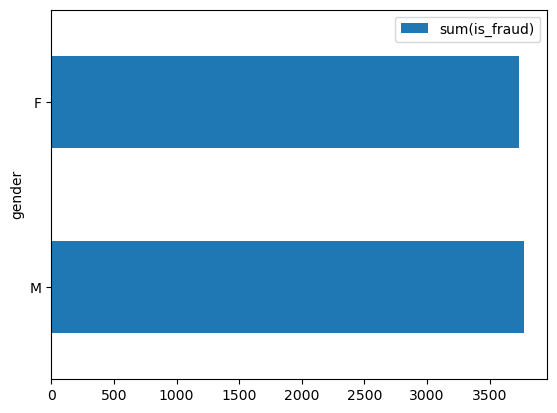

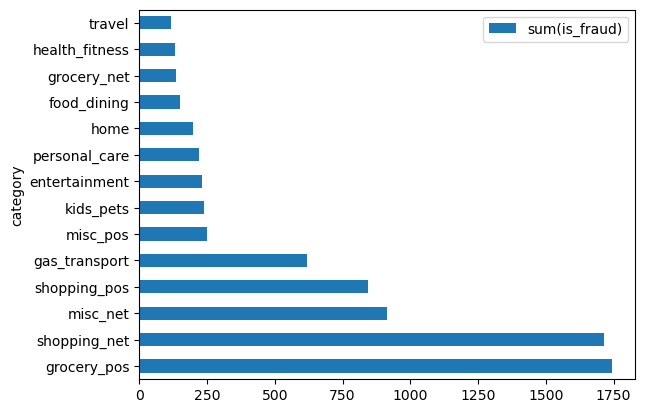

In [173]:
attrs = ["gender",  "category"]
for attr in tqdm(attrs):
    barplot(attr, "is_fraud")

<Axes: ylabel='city'>

<Axes: ylabel='state'>

<Axes: ylabel='job'>

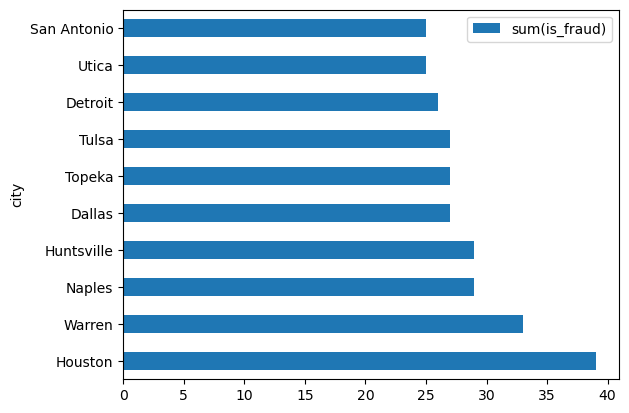

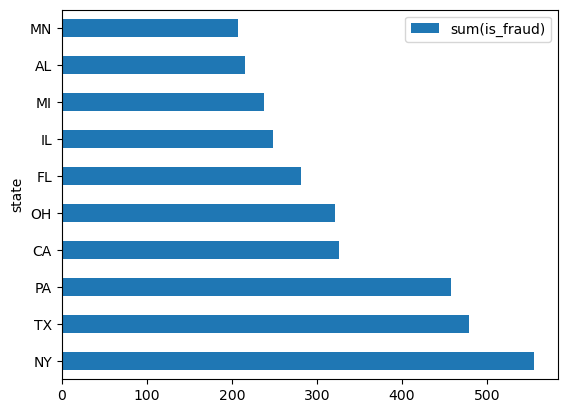

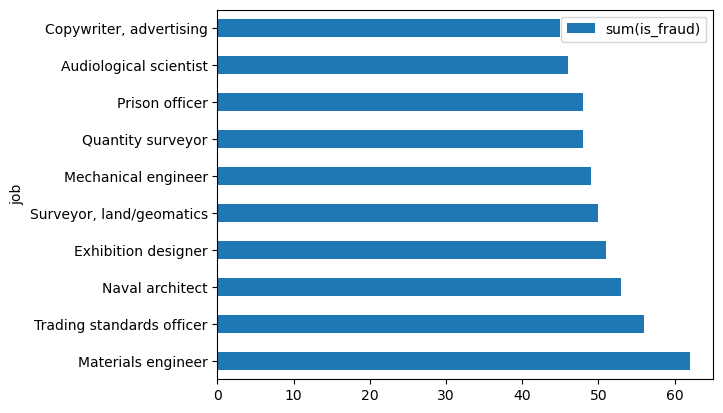

In [181]:
# TODO
# Top City, State and Job - isis_fraud
top_attrs = ["city", "state", "job"]
agg_val = "is_fraud"

for attr in top_attrs:
    agg = final_df.groupBy(attr).agg({agg_val:"sum"}).orderBy(f"sum({agg_val})", ascending=False)
    top_ten = agg.limit(10).toPandas()
    display(top_ten.plot.barh(attr, f"sum({agg_val})"))

## Geolocation

- showing the most occurence of fraudulent happened using coordinates

In [182]:
!pip install geopandas
!pip install folium

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.6/323.6 kB 1.1 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 1.8 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 1.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 1.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 552.1 kB/s eta 0:00:00a 0:00:01


In [252]:
is_fraud_true = final_df.filter(final_df.is_fraud == 1)

is_fraud_true.select("lat", "long").show()

+-------+---------+
|    lat|     long|
+-------+---------+
|35.9946| -81.7266|
|  29.44|  -98.459|
|  29.44|  -98.459|
|35.9946| -81.7266|
|  29.44|  -98.459|
|35.9946| -81.7266|
|35.9946| -81.7266|
|  29.44|  -98.459|
|  29.44|  -98.459|
|  29.44|  -98.459|
|40.3359| -79.6607|
|40.3359| -79.6607|
|40.3359| -79.6607|
|35.9946| -81.7266|
|40.3359| -79.6607|
|35.9946| -81.7266|
|35.9946| -81.7266|
|35.9946| -81.7266|
|  29.44|  -98.459|
|64.7556|-165.6723|
+-------+---------+
only showing top 20 rows



In [253]:
lon = is_fraud_true.select("long").collect()
lat = is_fraud_true.select("lat").collect()
lat_long = [[float(latitude.lat), float(longitude.long)] for longitude, latitude  in zip(lon, lat)]
len(lat_long)

7506

In [254]:
from folium import plugins
import folium
map = folium.Map(location=[15, 30], tiles="Cartodb dark_matter", zoom_start=2)
plugins.HeatMap(lat_long).add_to(map)

map

## Timeseries
    - merch_last_update_time_formatted_utc8 -- update time
    - merch_eff_time_formatted_utc8 -- registration time
    - trans_date_trans_time -- transaction time

In [308]:
ts_df = is_fraud_true.select("merch_last_update_time_formatted_utc8", "merch_eff_time_formatted_utc8", "trans_date_trans_time")
trf_time = ts_df.select("trans_date_trans_time")

In [309]:
trf_time = trf_time.withColumn("trf_date", to_date(col("trans_date_trans_time")))
agg_trf = trf_time.groupBy("trf_date").agg({"trf_date":"count"}).orderBy(col("trf_date").asc())
agg_trf_pdf = agg_trf.toPandas().set_index("trf_date")

In [310]:
agg_trf_pdf

,count(trf_date)
trf_date,
2019-01-02,7
2019-01-03,12
2019-01-04,13
2019-01-05,13
2019-01-06,2
...,...
2020-06-17,35
2020-06-18,39
2020-06-19,25


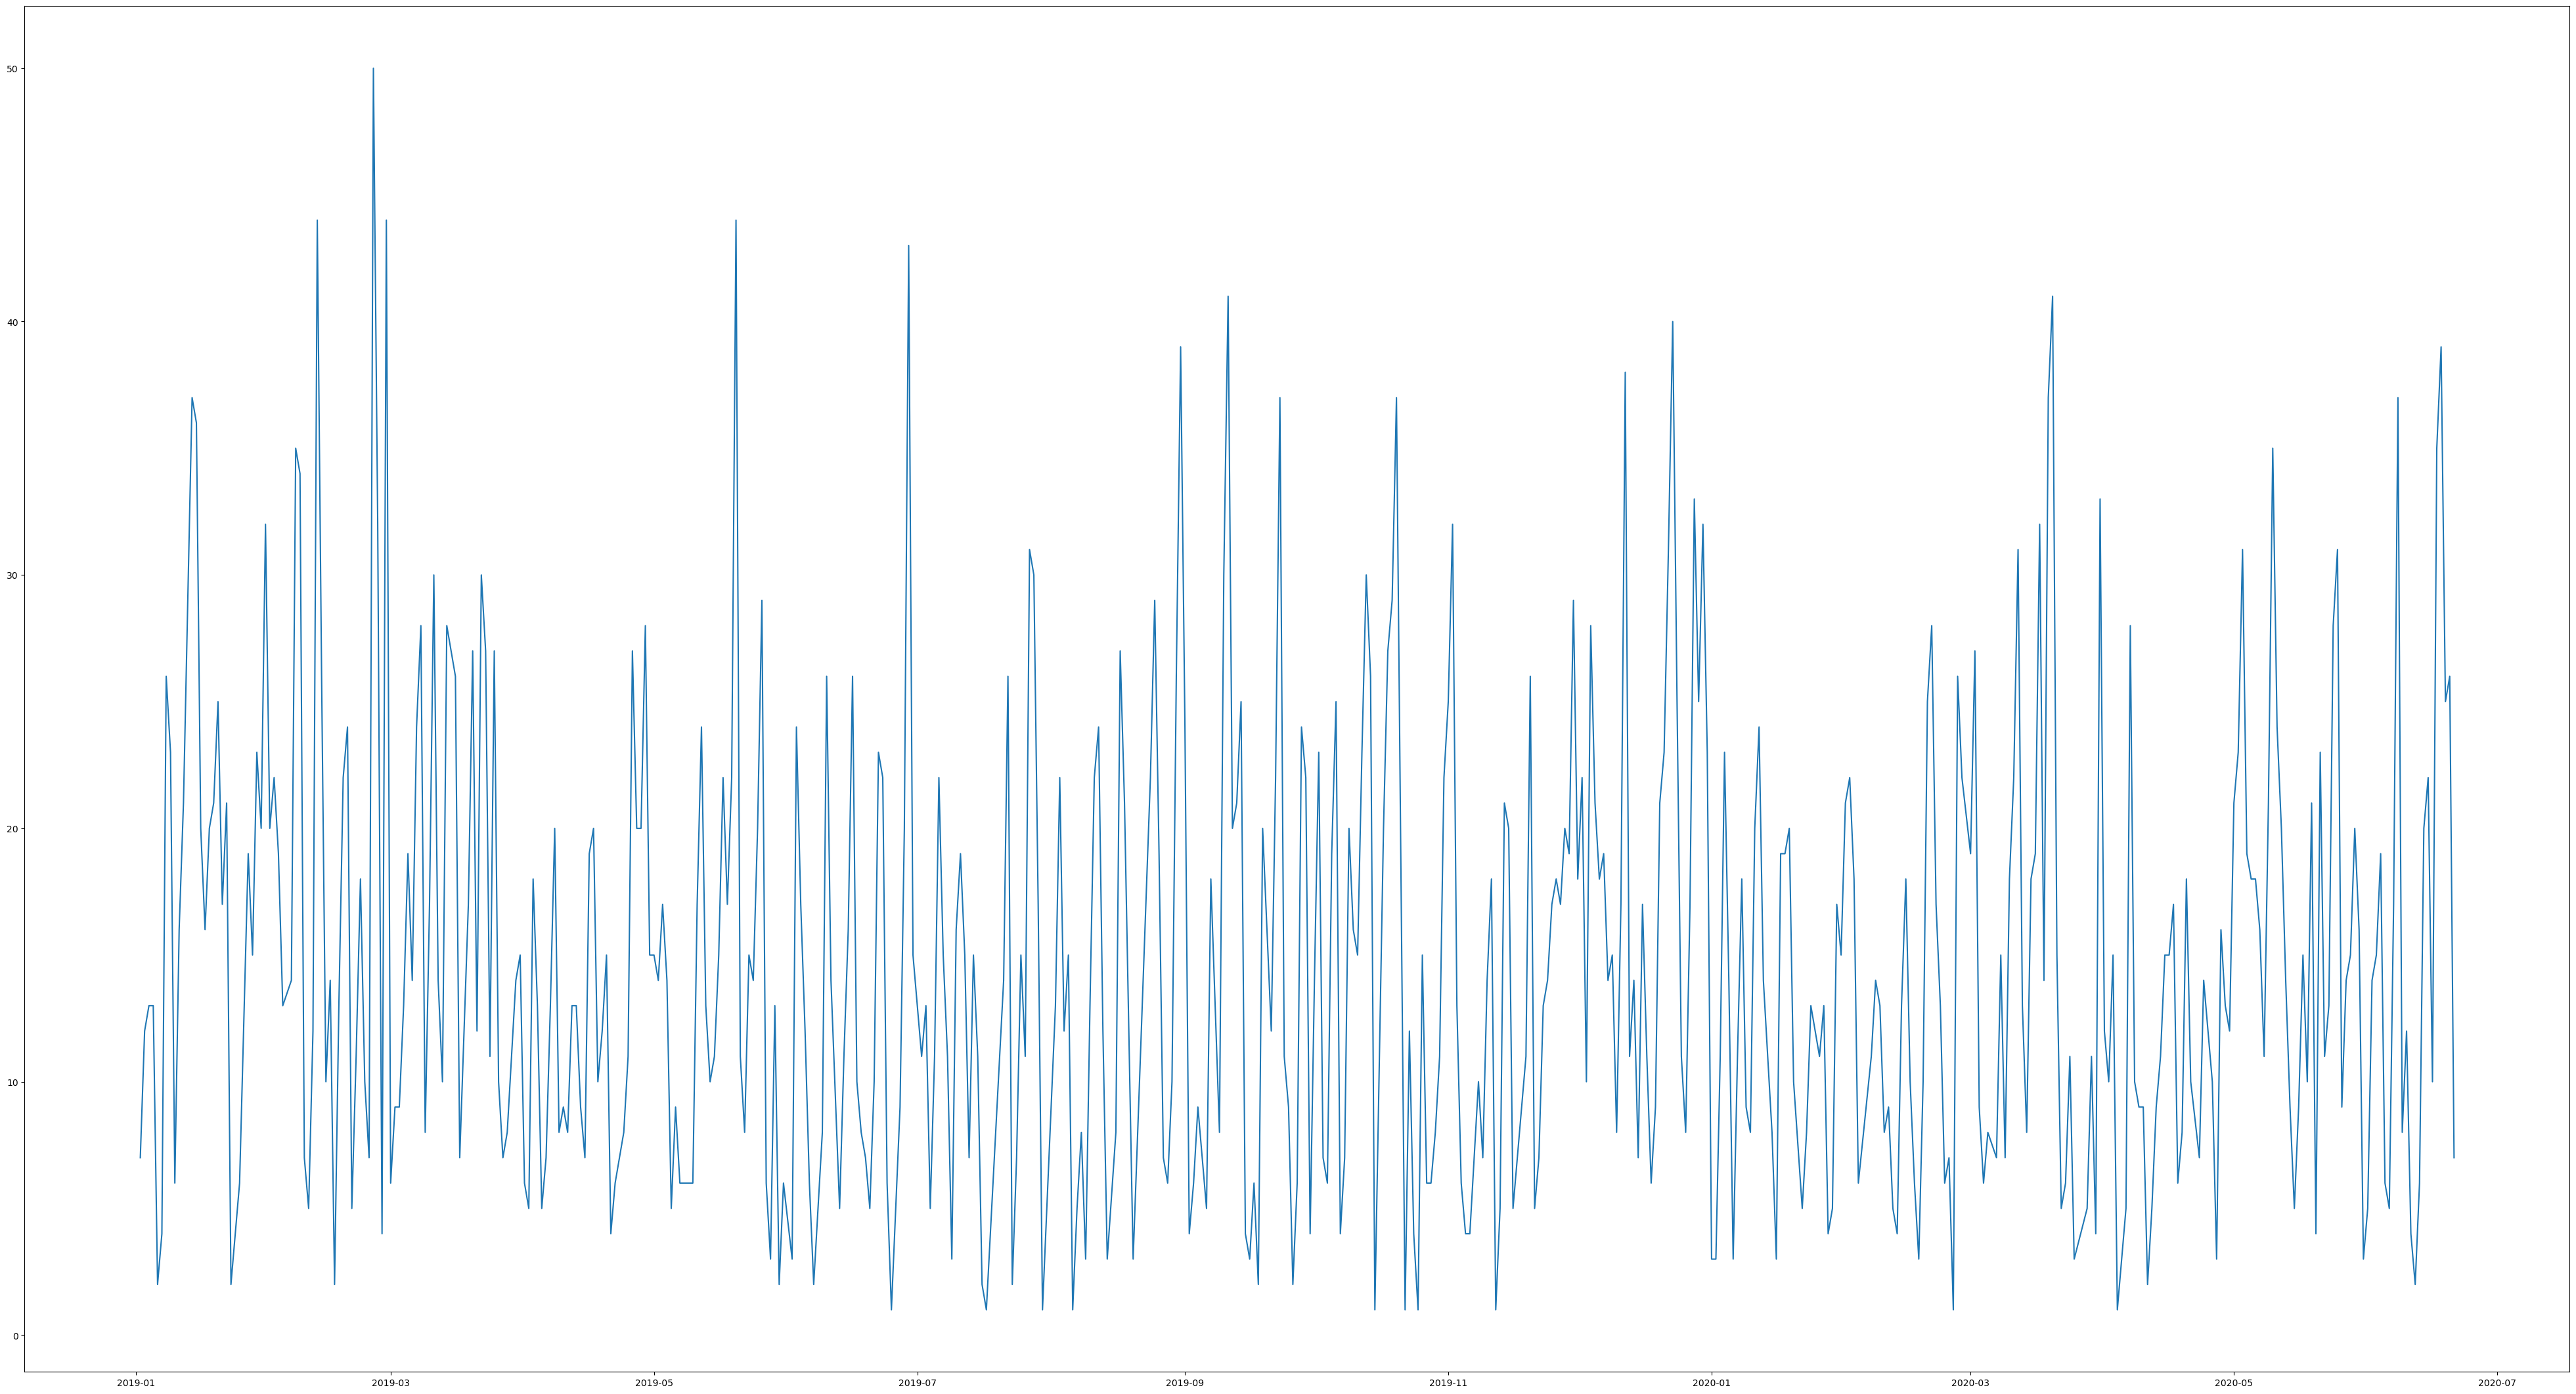

In [311]:
plt.figure(figsize=(50, 27))

plt.plot(agg_trf_pdf.index, agg_trf_pdf["count(trf_date)"])

In [312]:
# trf_time = trf_time.withColumn("trf_date", to_date(col("trans_date_trans_time")))
trf_time = trf_time.withColumn("trf_year", year(col("trans_date_trans_time")))
trf_time = trf_time.withColumn("trf_month", month(col("trans_date_trans_time")))

trf_time_2019 = trf_time.filter(trf_time.trf_year == 2019)
trf_time_2020 = trf_time.filter(trf_time.trf_year == 2020)


trf_time_2019_agg = trf_time_2019.groupBy("trf_month").count().orderBy(col("trf_month").asc())
trf_time_2020_agg = trf_time_2020.groupBy("trf_month").count().orderBy(col("trf_month").asc())

# agg_trf_pdf = agg_trf.toPandas().set_index("trf_year")
# plt.plot(agg_trf_pdf.index, agg_trf_pdf["count(trf_year)"])
# agg_trf.show()

Text(0.5, 1.0, 'Transaction pattern 2019')

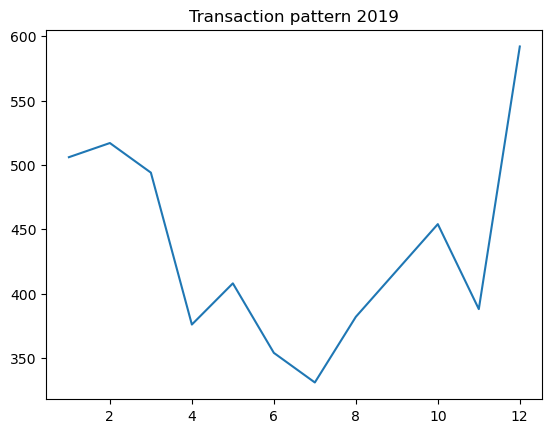

In [313]:
agg_trf_pdf_2019 = trf_time_2019_agg.toPandas().set_index("trf_month")
plt.plot(agg_trf_pdf_2019.index, agg_trf_pdf_2019["count"])
plt.title("Transaction pattern 2019")

Text(0.5, 1.0, 'Fraud Transaction pattern 2020')

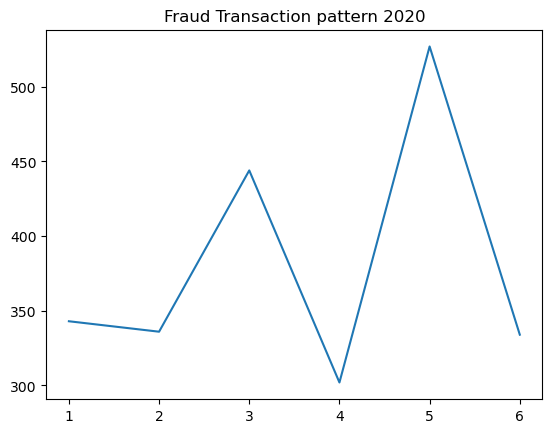

In [314]:
agg_trf_pdf_2020 = trf_time_2020_agg.toPandas().set_index("trf_month")
plt.plot(agg_trf_pdf_2020.index, agg_trf_pdf_2020["count"])
plt.title("Fraud Transaction pattern 2020")

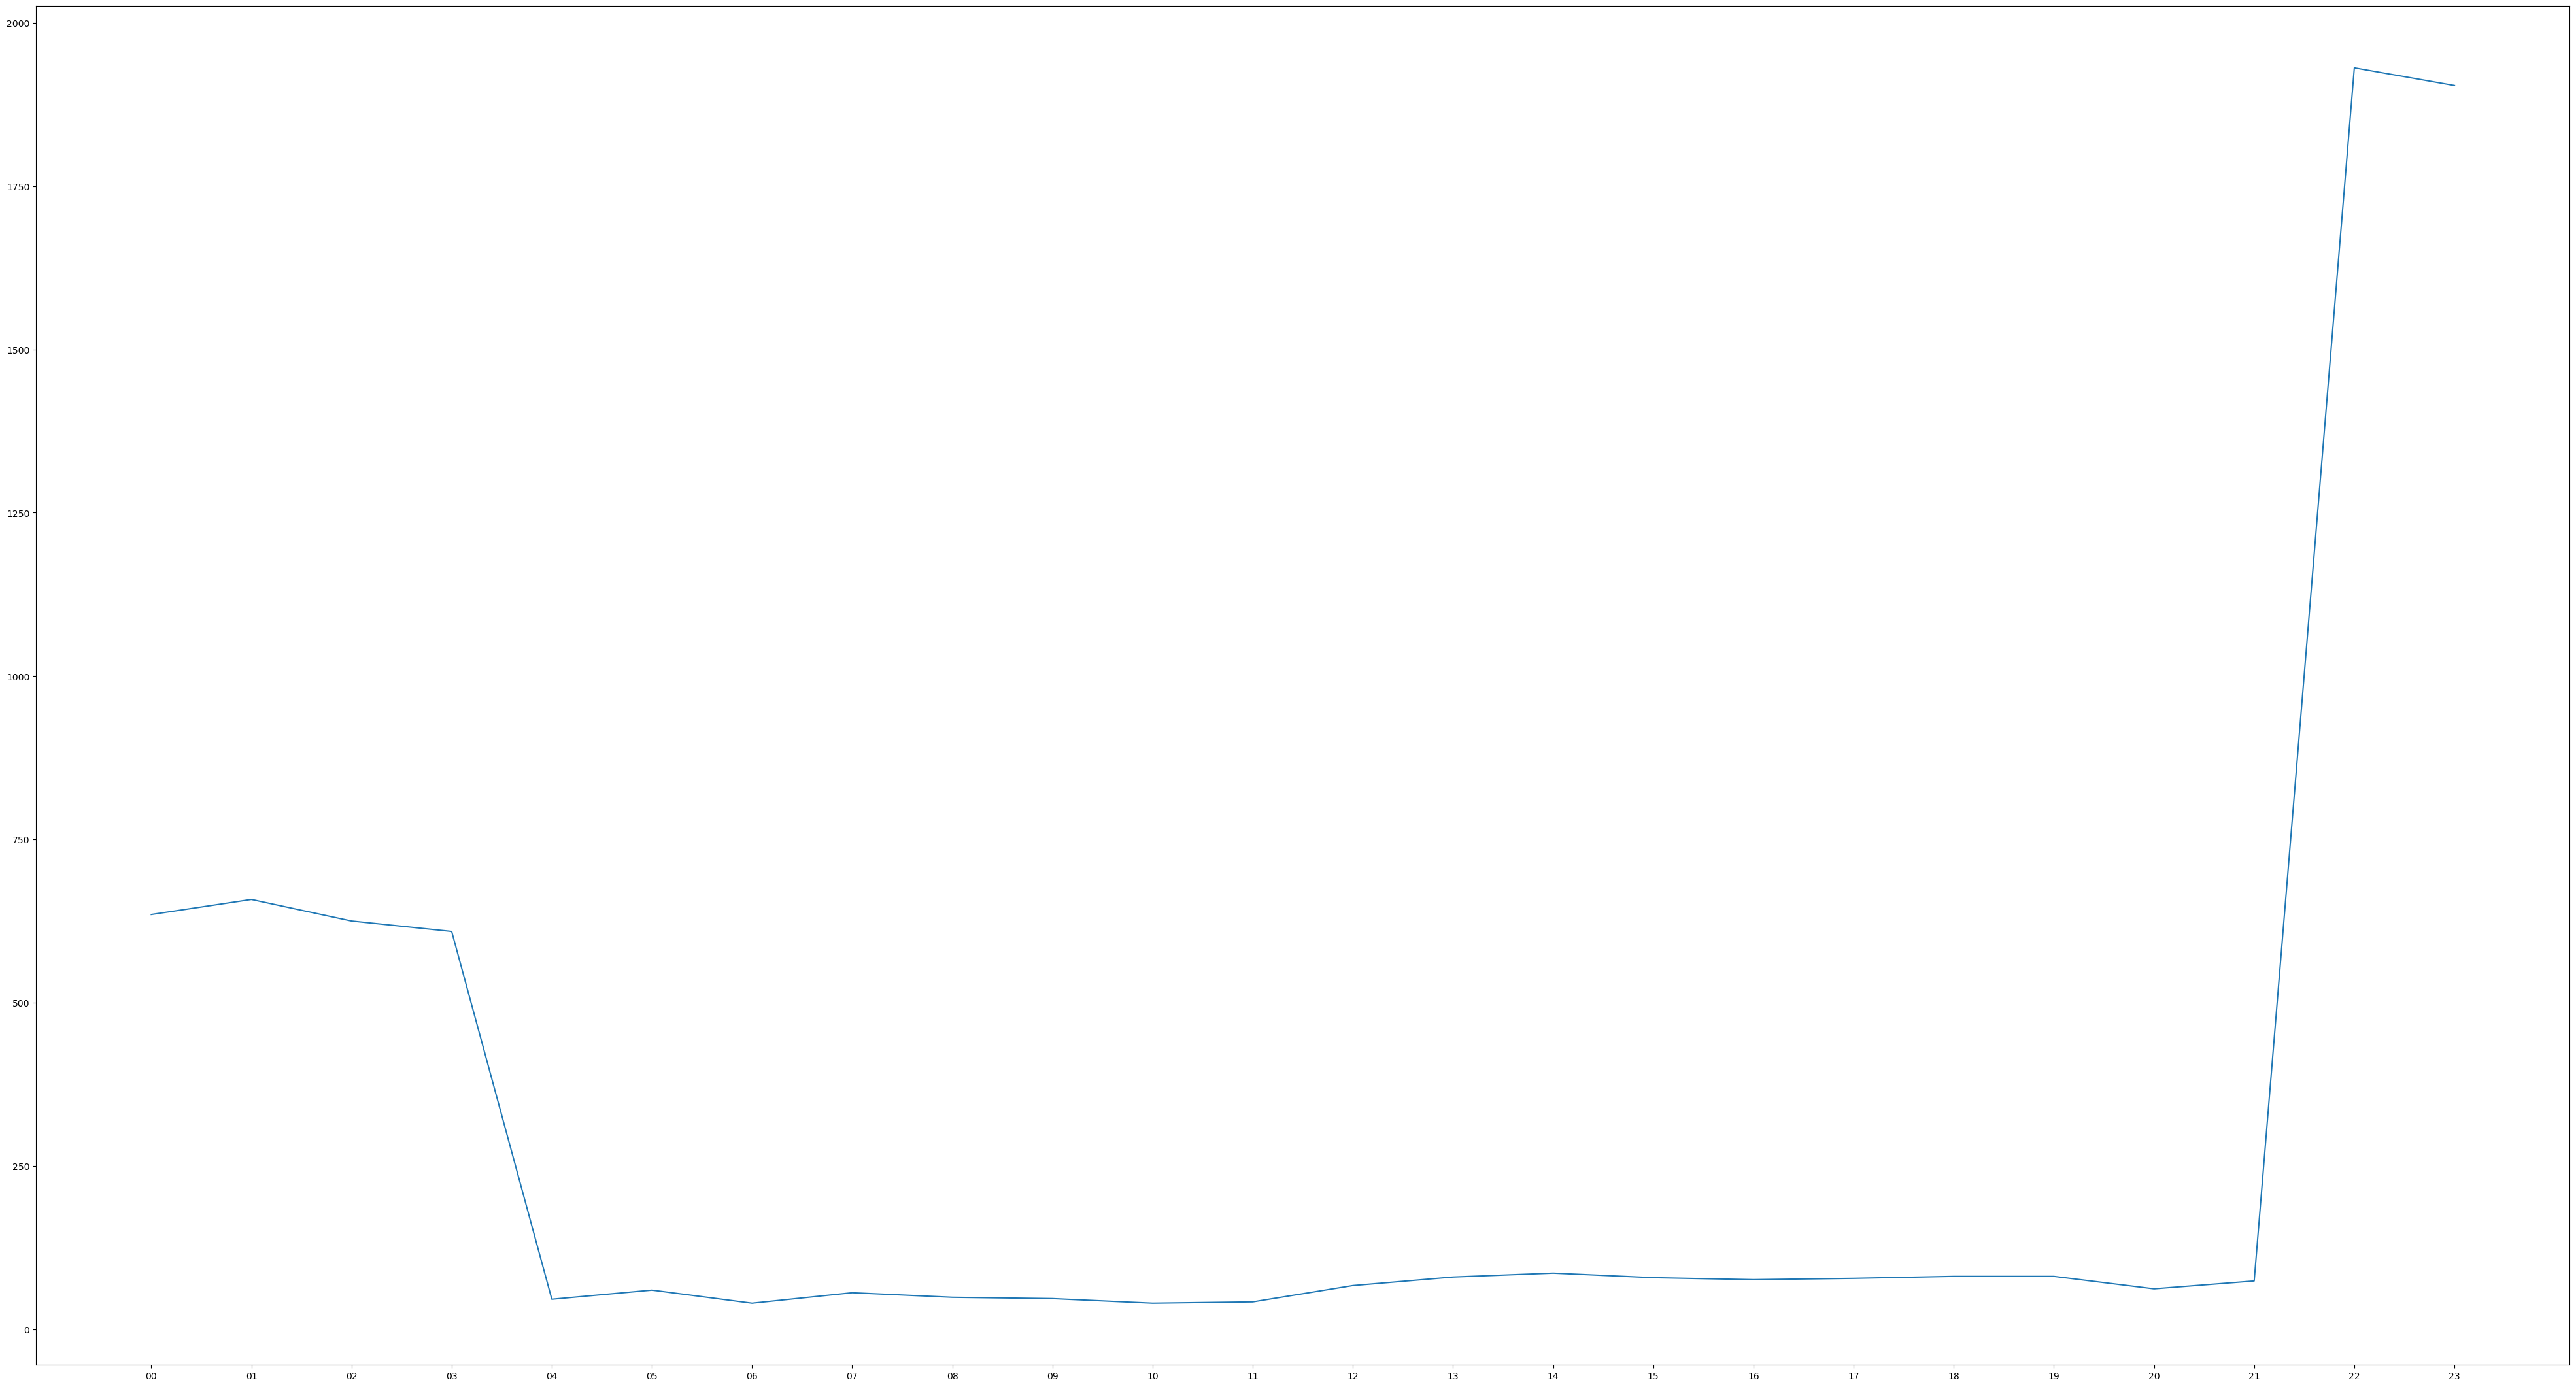

In [425]:
trf_time = trf_time.withColumn('trf_time', date_format('trans_date_trans_time', 'HH'))
trf_time_agg = trf_time.groupBy("trf_time").count().orderBy(col("trf_time").asc())
agg_trf_time_pdf = trf_time_agg.toPandas().set_index("trf_time")
plt.figure(figsize=(50, 27))
plt.plot(agg_trf_time_pdf.index, agg_trf_time_pdf["count"])

# Observation and Insights

1. Top 5 fraud name are - Scott Martin,  Jennifer Scot,   Robert Jam,      Susan G,       Linda.
2. Gender showed no significant different between Male and Female in terms of fraud activity.
3. Grocery pos, shopping net and misc net showed the highest category transaction in fraudulent.
4. Hauston, Warren and Naples are the location for the highest amount of fraudulent transaction.
5. Based on the timeseries graph of 2019, early and end of year showed the highest amount of fraudulent activity which require additional
information such divident month where people gain more money or, events occur.
6. While in 2020, the month data is not suffiecient enough to conculde the most amount of fraud activity, but it showed March and May where it was the
highest one.
7. Drilling down to the fraud behavior, we can see most of the fraud activity took at 10:00 to 3:00 AM. D 20|